In [28]:
import igraph as ig
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

In [30]:
name_list = ['human_neuron','rat_neuron',
            'monkey_neuron','zebrafish_neuron',
    'vascular_2','vascular_3','vascular_1','mitochondrial','root_1','root_2','anthill','fruit_fly_2','fruit_fly_3','fruit_fly_1','fruit_fly_4']
motif_number = 4
motif_counts_dict = {}
motif_counts_original_dict = {}
n_trials = 20
count = 1
for name in name_list:
    #print('******',name)
    path_source = '../1. data/3. final_data/'
    link_paths = pd.read_csv(path_source +name + '.paths.csv',index_col=[0])
    path_bodyid_list = link_paths[['path_id','source','target']].drop_duplicates().values.tolist()
    path_bodyid_dict = {}  
    bodyid_path_dict = {}
    for path_bodyid in path_bodyid_list:
        path_bodyid_dict[path_bodyid[0]] =  (path_bodyid[1],path_bodyid[2])
        bodyid_path_dict[(path_bodyid[1],path_bodyid[2])] = path_bodyid[0]
        bodyid_path_dict[(path_bodyid[2],path_bodyid[1])] = path_bodyid[0] 
    edge_list = []
    for path_id,bodyid_edge in path_bodyid_dict.items():
        edge_list.append([bodyid_edge[0],bodyid_edge[1]])
    df = pd.DataFrame(edge_list)
    G = nx.MultiGraph()
    G.add_edges_from(edge_list)
    degrees = dict(G.degree)
    degree_sequence = degrees.values()
    g = ig.Graph(n=len(df), edges=[(v,w) for v,w in df.values] )
    motif_counts_original =g.motifs_randesu(motif_number)
    motif_counts_original_dict[name]=motif_counts_original
    motif_counts_dict[name] = {}
    for trial in range(0,n_trials):
        count += 1
        G_conf = nx.configuration_model(degree_sequence, create_using=nx.MultiGraph(),seed = trial*count)
        df = pd.DataFrame(G_conf.edges())
        g = ig.Graph(n=len(df), edges=[(v,w) for v,w in df.values] )
        motif_counts=g.motifs_randesu(motif_number)
        motif_counts_dict[name][trial] = motif_counts

In [18]:
z_scores_dict = {}
mean_dict = {}
std_dict = {}
for name in name_list:
    z_scores_dict[name] = {}
    mean_dict[name] = {}
    std_dict[name] = {}
    for motif_index in range(0,len(motif_counts_original_dict[name])):
        motif_value_list = []
        for trial in range(0,n_trials):
            motif_value_list.append(motif_counts_dict[name][trial][motif_index])
        z_score = (motif_counts_original_dict[name][motif_index] - np.mean(motif_value_list))/np.std(motif_value_list)
        mean_dict[name][motif_index] = np.mean(motif_value_list)
        std_dict[name][motif_index] = np.std(motif_value_list)
        z_scores_dict[name][motif_index] = z_score

<ipython-input-18-409981c3c427>:12: RuntimeWarning: invalid value encountered in double_scalars
  z_score = (motif_counts_original_dict[name][motif_index] - np.mean(motif_value_list))/np.std(motif_value_list)
<ipython-input-18-409981c3c427>:12: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = (motif_counts_original_dict[name][motif_index] - np.mean(motif_value_list))/np.std(motif_value_list)


Text(0.5, 1.0, 'Motif 4 counts')

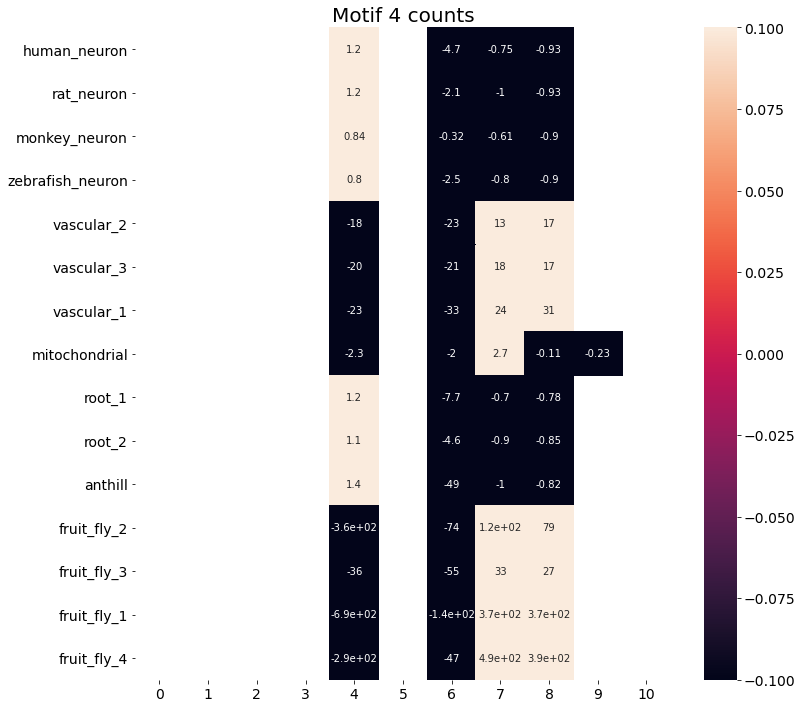

In [19]:
all_motifs = pd.DataFrame(z_scores_dict).transpose()
plt.figure(figsize=(12,12))
sns.heatmap(all_motifs,annot=True);
plt.title('Motif 4 counts')

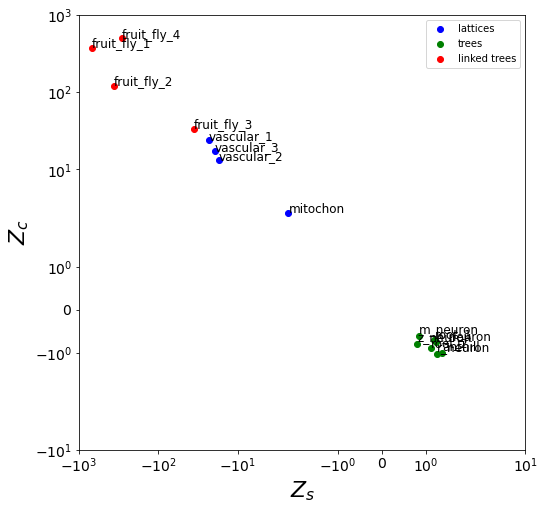

In [35]:
plt.figure(figsize=(8,8))
name_change_dict = {'zebrafish_neuron':'z_neuron','human_neuron':'h_neuron','monkey_neuron':'m_neuron','mitochondrial':'mitochon','rat_neuron':'r_neuron'}
index_1 = 4
index_2 = 7
for name in all_motifs.index:
    #print(name)
    df_row = all_motifs[all_motifs.index == name]
    
    x = df_row[index_1]
    y = df_row[index_2]
    if name in name_change_dict.keys():
        name = name_change_dict[name]
    plt.text((x+0.01),(y + 0.05), name, fontsize=12)
        
l_x = []
l_y = []
t_x = []
t_y = []
cn_x = []
cn_y = []
for name in all_motifs.index:
    #print(name)
    df_row = all_motifs[all_motifs.index == name]
    
    #x = df_row[4]
    #y = df_row[8]
    if ('vascular') in name or ('mito' in name):
        l_x.append(df_row[index_1])
        l_y.append(df_row[index_2])
    elif 'fruit_fly' in name:
        cn_x.append(df_row[index_1])
        cn_y.append(df_row[index_2])
    else:
        t_x.append(df_row[index_1])
        t_y.append(df_row[index_2])
plt.scatter(l_x,l_y,label='lattices',color='blue')
plt.scatter(t_x,t_y,label='trees',color='green')
plt.scatter(cn_x,cn_y,label='linked trees',color='red')
plt.xlabel('$Z_{s}$',fontsize=22)
plt.ylabel('$Z_{c}$',fontsize=22)
plt.legend()
plt.ylim(-10,1000)
plt.xlim(-1000,10)
plt.xscale('symlog')
plt.yscale('symlog')
plt.savefig('abstract_network_motifs.pdf', format='pdf',dpi=1200)

In [40]:
# Creating DataFrames from dictionaries and transposing
df_mean = pd.DataFrame(mean_dict).transpose()[[4, 8]]
df_std = pd.DataFrame(std_dict).transpose()[[4, 8]]
df_original = pd.DataFrame(motif_counts_original_dict).transpose()[[4, 8]]

# Renaming columns for clarity
df_mean.columns = [f'mean_{col}' for col in df_mean.columns]
df_std.columns = [f'std_{col}' for col in df_std.columns]
df_original.columns = [f'original_{col}' for col in df_original.columns]

# Merging the DataFrames
df_merged = pd.concat([df_original,df_mean, df_std], axis=1)
df_merged.columns = ['$N_{s}$','$N_{c}$','$\mu_{s}$','$\mu_{c}$','$\sigma_{s}$','$\sigma_{c}$']


df_merged['$Z_{s}$'] = (df_merged['$N_{s}$'] - df_merged['$\mu_{s}$']) / df_merged['$\sigma_{s}$']
df_merged['$Z_{c}$'] = (df_merged['$N_{c}$'] - df_merged['$\mu_{c}$']) / df_merged['$\sigma_{c}$']
df_merged

,$N_{s}$,$N_{c}$,$\mu_{s}$,$\mu_{c}$,$\sigma_{s}$,$\sigma_{c}$,$Z_{s}$,$Z_{c}$
human_neuron,395.0,0.0,390.90,0.55,3.360060,0.589491,1.220216,-0.933008
rat_neuron,92.0,0.0,88.60,0.55,2.727636,0.589491,1.246500,-0.933008
monkey_neuron,129.0,0.0,120.40,0.75,10.268398,0.829156,0.837521,-0.904534
zebrafish_neuron,185.0,0.0,178.95,0.60,7.572813,0.663325,0.798911,-0.904534
vascular_2,853.0,29.0,931.20,2.55,4.467662,1.564449,-17.503564,16.906913
vascular_3,709.0,21.0,786.10,1.95,3.923009,1.116915,-19.653281,17.055902
vascular_1,1613.0,58.0,1727.00,2.35,4.898979,1.768474,-23.270153,31.467809
mitochondrial,36.0,1.0,43.70,1.15,3.318132,1.351851,-2.320583,-0.110959
root_1,627.0,0.0,622.00,0.70,4.207137,0.900000,1.188457,-0.777778
root_2,333.0,0.0,321.30,0.50,10.540873,0.591608,1.109965,-0.845154
